In [1]:
from homeharvest import scrape_property
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [2]:
# Generate filename based on current timestamp
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"HomeHarvest_{current_timestamp}.csv"

# properties = scrape_property(
#   location="New York City, NY",
#   listing_type="for_sale",  # or (for_sale, for_rent, pending)
#   past_days=60,  # sold in last 30 days - listed in last 30 days if (for_sale, for_rent)

#   # property_type=['single_family','multi_family'],
#   # date_from="20235-05-01", # alternative to past_days
#   # date_to="2025-05-08",
#   # foreclosure=True
#   # mls_only=True,  # only fetch MLS listings
# )
# print(f"Number of properties: {len(properties)}")

# Export to csv
# properties.to_csv(filename, index=False)
# print(properties.head())

In [3]:
def read_data(file_name):
    """
    Read the data from the file and return a Pandas DataFrame
    file_name: str, name of the file to read
    return: Pandas DataFrame
    """
    return pd.read_csv(file_name)

data = read_data("HomeHarvest_20250507_165235.csv")
display(data)

,property_url,property_id,listing_id,mls,mls_id,status,text,style,full_street_line,street,...,builder_id,builder_name,office_id,office_mls_set,office_name,office_email,office_phones,nearby_schools,primary_photo,alt_photos
0,https://www.realtor.com/realestateandhomes-det...,9933232165,2981521178,LINY,858869,FOR_SALE,"Bright and Sunny, Move-In Ready, First Floor U...",COOP,71-04 Little Neck Pkwy Unit 134A,71-04 Little Neck Pkwy,...,NaN,NaN,33497.0,O-LINY-CAPU01,ERA Caputo Realty,info@eracaputo.com,"[{'number': '5164370333', 'type': 'Office', 'p...","New York City Special Schools - District 75, N...",https://ap.rdcpix.com/e54a94e768254ec35244deb5...,https://ap.rdcpix.com/e54a94e768254ec35244deb5...
1,https://www.realtor.com/realestateandhomes-det...,4092166893,2981505702,LINY,855614,FOR_SALE,Welcome to 324 E 239th Street a beautifully ma...,SINGLE_FAMILY,324 E 239th St,324 E 239th St,...,NaN,NaN,NaN,O-LINY-HOULAW44,Houlihan Lawrence Inc.,NaN,"[{'number': '9143611065', 'type': None, 'prima...",New York City Geographic District #11,https://ap.rdcpix.com/258848de5e685685a61d4f31...,https://ap.rdcpix.com/258848de5e685685a61d4f31...
2,https://www.realtor.com/realestateandhomes-det...,4724259152,2981507298,DENY,23438160,FOR_SALE,Experience loft-like living in the heart of Pa...,COOP,353 2nd St Apt 4L,353 2nd St,...,NaN,NaN,2277867.0,O-DENY-78,187 Seventh Ave,lead.manager@elliman.com,"[{'number': '7188402000', 'type': 'Office', 'p...","New York City Geographic District #15, New Yor...",https://ap.rdcpix.com/a85bb856d77a1cfb7743adae...,https://ap.rdcpix.com/a85bb856d77a1cfb7743adae...
3,https://www.realtor.com/realestateandhomes-det...,4627494204,2981517836,SINY,2502585,FOR_SALE,Prime Location - Newly Renovated Townhouse wit...,TOWNHOMES,12 Seagate Ct,12 Seagate Ct,...,NaN,NaN,NaN,O-SINY-O21801,Connie Profaci Realty,cprofaci@aol.com,"[{'number': '7186679100', 'type': None, 'prima...",Hawthorne-Cedar Knolls Union Free School Distr...,https://ap.rdcpix.com/65b884647cb88194553e3737...,https://ap.rdcpix.com/65b884647cb88194553e3737...
4,https://www.realtor.com/realestateandhomes-det...,3433776828,2981528345,SINY,2502601,FOR_SALE,Vacant land partially located in NYSEDC wetlan...,LAND,Stobe Ave,Stobe Ave,...,NaN,NaN,NaN,O-SINY-O31001X,"V.I.P. Real Estate, Inc.",susan@viprealestate.net,"[{'number': '7189672600', 'type': None, 'prima...","New York State Office of Mental Health, New Yo...",https://ap.rdcpix.com/ae354b7192cfad319274d1f8...,https://ap.rdcpix.com/ae354b7192cfad319274d1f8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,https://www.realtor.com/realestateandhomes-det...,3724580129,2980301624,BONY,490710,PENDING,"2-Bed, 2-Bath Condo with 2 Balconies, Parking,...",CONDOS,1812 Quentin Rd Apt 6B,1812 Quentin Rd,...,NaN,NaN,NaN,O-BONY-118850,Tworealestate Llc,art@tworealestate.com,"[{'number': '(718) 218-5213', 'type': 'Office'...","New York City Geographic District #22, NEW VIS...",https://ap.rdcpix.com/ad04abb95d9f53942f1847c9...,https://ap.rdcpix.com/ad04abb95d9f53942f1847c9...
6428,https://www.realtor.com/realestateandhomes-det...,9382487142,2980301374,LINY,L3585632,FOR_SALE,NaN,CONDOS,136-80 41 Ave Unit 3H,136-80 41 Ave,...,NaN,NaN,NaN,O-LINY-BTR02,United Real Estate Fortune,unitedrefortune@gmail.com,"[{'number': '5169908888', 'type': None, 'prima...",New York City Geographic District #25,https://ap.rdcpix.com/f6c92123fef07a49689270ef...,https://ap.rdcpix.com/f6c92123fef07a49689270ef...
6429,https://www.realtor.com/realestateandhomes-det...,3930157808,2977020157,LINY,811358,FOR_SALE,This charming semi-detached corner brick two-f...,MULTI_FAMILY,186-02 Foch Blvd,186-02 Foch Blvd,...,NaN,NaN,2936620.0,O-LINY-HMSM01,HomeSmart Premier Living Realty,rraspantini@coachrealtors.com,"[{'number': '5165359692', 'type': 'Office', 'p...","Riverton Street Charter School, New York City ...",https://ap.rdcpix.com/6758ff8ec4f4d2d8e74eec12...,https://ap.rdcpix.com/6758ff8ec4f4d2d8e74eec12...
6430,https://w

In [4]:
def pre_process(data):
    """
    Preprocess the data
    data: Pandas DataFrame
    return: Pandas DataFrame
    """
    data = data.dropna(subset=['sqft', 'list_price'])
    # data = data[data['lot_sqft'] < 100000]
    # data = data[data['list_price'] < 15000000]
    data["nearby_schools"] = data["nearby_schools"].fillna("")
    data["half_baths"] = data["half_baths"].fillna(0)
    data["parking_garage"] = data["parking_garage"].fillna(0)
    data["full_baths"] = data["full_baths"].fillna(0)
    data["beds"] = data["beds"].fillna(0)
    data["stories"] = data["stories"].fillna(1)
    data["year_built"] = data["year_built"].fillna(data["year_built"].median())
    data["num_schools"] = data["nearby_schools"].apply(lambda x : x.count(",") + 1 if x else 0)
    print(datetime.now().year)
    data["house_age"] = datetime.now().year - data["year_built"]
    data.drop("year_built", axis=1, inplace=True)
    trimColumns = ['lot_sqft', 'property_url','property_id','listing_id','mls','mls_id','status','text','full_street_line','street','unit','city','state','zip_code','days_on_mls','list_price_min','list_price_max','sold_price','last_sold_date','assessed_value','estimated_value','tax','tax_history','new_construction','price_per_sqft', 'latitude','longitude','neighborhoods','county','fips_code','hoa_fee','agent_id','agent_name','agent_email','agent_phones','agent_mls_set','agent_nrds_id','broker_id','broker_name','builder_id','builder_name','office_id','office_mls_set','office_name','office_email','office_phones','primary_photo','alt_photos', 'nearby_schools', 'list_date']
    data = data.drop(trimColumns, axis = 1)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encodedData = encoder.fit_transform(data[["style"]])
    encodedCols = encoder.get_feature_names_out(['style'])
    dataframeEncodings = pd.DataFrame(encodedData, columns=encodedCols, index=data.index)
    data = data.drop(columns=["style"]).join(dataframeEncodings)
    return data
clean_data = pre_process(data)
display(clean_data)

2025


C:\Users\david\AppData\Local\Temp\ipykernel_53964\2770898337.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["nearby_schools"] = data["nearby_schools"].fillna("")
C:\Users\david\AppData\Local\Temp\ipykernel_53964\2770898337.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["half_baths"] = data["half_baths"].fillna(0)
C:\Users\david\AppData\Local\Temp\ipykernel_53964\2770898337.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,beds,full_baths,half_baths,sqft,list_price,stories,parking_garage,num_schools,house_age,style_APARTMENT,style_CONDOP,style_CONDOS,style_COOP,style_MOBILE,style_MULTI_FAMILY,style_SINGLE_FAMILY,style_TOWNHOMES
0,1.0,1.0,0.0,575.0,239000.0,1.0,0.0,3,75.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,4.0,1.0,1.0,1441.0,699000.0,1.0,0.0,1,124.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.0,1.0,1.0,2060.0,648888.0,3.0,1.0,3,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3.0,2.0,0.0,1260.0,685000.0,2.0,0.0,2,105.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,4.0,2.0,1.0,4075.0,1450000.0,2.0,1.0,4,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2.0,1.0,0.0,1057.0,715000.0,1.0,0.0,2,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6428,0.0,1.0,0.0,515.0,621205.0,1.0,0.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6429,4.0,3.0,0.0,2042.0,889000.0,1.0,2.0,2,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6430,5.0,2.0,0.0,1510.0,500000.0,1.0,0.0,2,65.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
targetVariable = 'sqft'
def train_model_rforests(data):
    dataX = data.drop(columns=[targetVariable])
    targetY = data[targetVariable]
    X_train, X_test, y_train, y_test = train_test_split(dataX, targetY, test_size=0.3)
    model = RandomForestRegressor(random_state=69)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"(Random Forest) Test MSE: {mse:,.2f}")
    print(f"(Random Forest) Test R^2: {r2:.4f}")

def train_model_linear(data):
    dataX = data.drop(columns=[targetVariable])
    targetY = data[targetVariable]
    scaler = StandardScaler()
    dataX = scaler.fit_transform(dataX)
    X_train, X_test, y_train, y_test = train_test_split(dataX, targetY, test_size=0.3)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Linear Model Coefficients:", model.coef_)
    print("Linear Model Intercept:", model.intercept_)

    print(f"(Linear Model) Test MSE: {mse:,.2f}")
    print(f"(Linear Model) Test R^2: {r2:.4f}")

train_model_linear(clean_data)
print('')
train_model_rforests(clean_data)

Linear Model Coefficients: [ 214.70288023  294.21888955  151.21966337  467.47075824  -25.29967452
   -2.10001607   35.49383697   30.75607062  -15.04770759  -10.36941195
 -150.39654394  -71.26869306   39.28722138  200.24278029   24.49408234
   59.39486304]
Linear Model Intercept: 1641.5365453815032
(Linear Model) Test MSE: 446,259.42
(Linear Model) Test R^2: 0.6784

(Random Forest) Test MSE: 301,527.04
(Random Forest) Test R^2: 0.7260


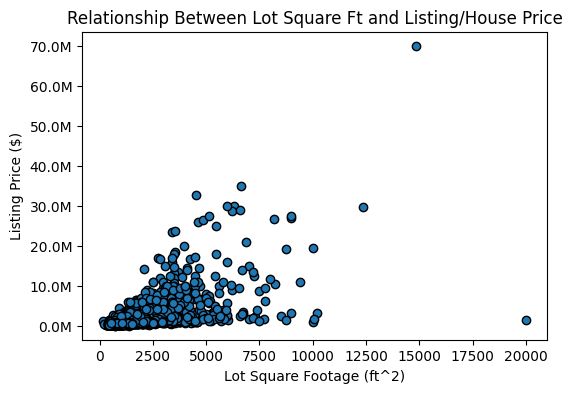

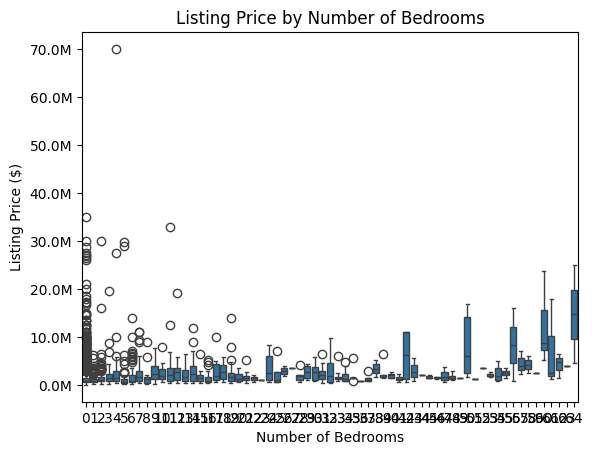

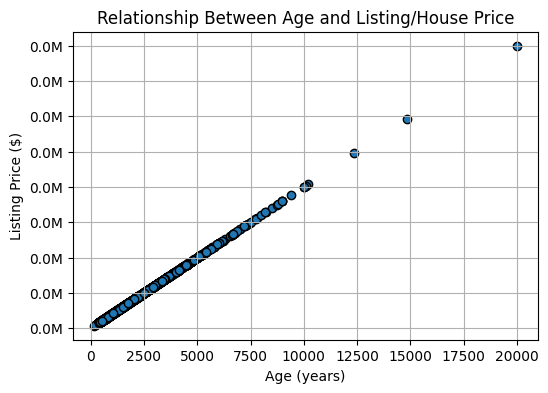

In [6]:
# style_APARTMENT	style_CONDOP	style_CONDOS	style_COOP	style_MOBILE	style_MULTI_FAMILY	style_SINGLE_FAMILY	style_TOWNHOMES
filtered_data = clean_data

plt.figure(figsize=(6, 4))
plt.scatter(filtered_data["sqft"], filtered_data["list_price"], edgecolors='k')
plt.title("Relationship Between Lot Square Ft and Listing/House Price")
plt.xlabel("Lot Square Footage (ft^2)")
plt.ylabel("Listing Price ($)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.show()

sns.boxplot(x="stories", y="list_price", data=filtered_data)
plt.title("Listing Price by Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Listing Price ($)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(filtered_data["sqft"], filtered_data["sqft"], edgecolors='k')
plt.title("Relationship Between Age and Listing/House Price")
plt.xlabel("Age (years)")
plt.ylabel("Listing Price ($)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.grid(True)
plt.show()